## Import libraries :

In [ ]:
!pip install gensim


In [ ]:
import nltk
import re
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import gensim.downloader as api
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Embedding, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

##  1. choose a representative sample

In [ ]:
import pandas as pd
#load data
url = "https://raw.githubusercontent.com/ironhack-labs/project-nlp-challenge/refs/heads/main/dataset/data.csv"
df = pd.read_csv(url)

df.head()

,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
#check dataset size
rows, cols = df.shape
print(f"Dataset contains {rows} rows and {cols} columns.")

Dataset contains 39942 rows and 5 columns.


In [ ]:
#drop unwanted columns
df = df.drop(columns=['date','subject','text'],axis=1)

In [ ]:
#select 20% of the data
sample = df.sample(frac=0.2, random_state=42)
sample.head()

,label,title
6524,1,Oil business seen in strong position as Trump ...
30902,0,WHOA! COLLEGE SNOWFLAKE FREAKS OUT: Screams Fo...
36459,0,CRONY CORRUPT POLITICS: Obama Admin BLOCKED FB...
9801,1,Cruz campaign vetting Fiorina as a possible VP...
25638,0,Minnesota Woman Writes Amazing F*ck Off Lette...


In [ ]:
sample.shape

(7988, 2)

## Text pre-processing

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
  text = text.lower()  # Convert to lowercase
  text = re.sub(r'[^\w\s]', '', text) # # remove all the punctuation
  tokens = word_tokenize(text)  # Tokenization
  tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
  tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
  return ' '.join(tokens)



In [ ]:
#TF-IDF
def Tfid_v(text):
    vectorizer_Tfidf = TfidfVectorizer(
        preprocessor=preprocess_text,
        ngram_range=(1,2),
        max_features=2500  # Keep only the 2500 most frequent words
    )

    tokens = vectorizer_Tfidf.fit_transform(text)
    features = vectorizer_Tfidf.get_feature_names_out()
    x_df = pd.DataFrame(tokens.toarray(), columns=features)

    return x_df, vectorizer_Tfidf  # Return features and trained vectorizer


 #CountVectorizer
def create_features(text):
    vectorizer = CountVectorizer(
        preprocessor=preprocess_text,
        ngram_range=(1,2),
        max_features=2500 # Keep only the 2500 most frequent words
    )
    tokens = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names_out()
    x_df = pd.DataFrame(tokens.toarray(), columns=features)
    return x_df, vectorizer

#apply
def apply_features(text, vectorizer):
    tokens = vectorizer.transform(text)
    features = vectorizer.get_feature_names_out()
    x_df = pd.DataFrame(tokens.toarray(), columns=features)
    return x_df




## spilt to train_test_split


In [ ]:
#spilt to train_test_split
x_train, x_test, y_train, y_test = train_test_split(sample.title,sample.label, test_size=0.2, random_state=42)

## Label Encoding

In [ ]:
# Encoding categorical target labels into numerical values
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_encoded_test = label_encoder.transform(y_test)

## Feature Extraction

In [ ]:
#CountVectorizer
# Extract features from training data and store the vectorizer
x_train_feat, vectorizer = create_features(x_train)

# Apply the same transformation to test data
x_test_feat = apply_features(x_test, vectorizer)

In [ ]:
#TF-IDF
# Convert training data to TF-IDF features and store the vectorizer
x_train_Tfidf,  vectorizer_Tfidf = Tfid_v(x_train)

# Apply the same TF-IDF transformation to test data
x_test_Tfidf = apply_features(x_test,  vectorizer_Tfidf)

##  Logistic Regression model

In [ ]:
## Train a simple Logistic Regression model using CountVectorizer features
Lr_c = LogisticRegression()
Lr_c.fit(x_train_feat, y_encoded_train)

predictions = Lr_c.predict(x_test_feat)
accuracy_s = accuracy_score(y_encoded_test, predictions)
print(f"Model Accuracy: {accuracy_s:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, predictions))

Model Accuracy: 0.9161
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       805
           1       0.89      0.95      0.92       793

    accuracy                           0.92      1598
   macro avg       0.92      0.92      0.92      1598
weighted avg       0.92      0.92      0.92      1598



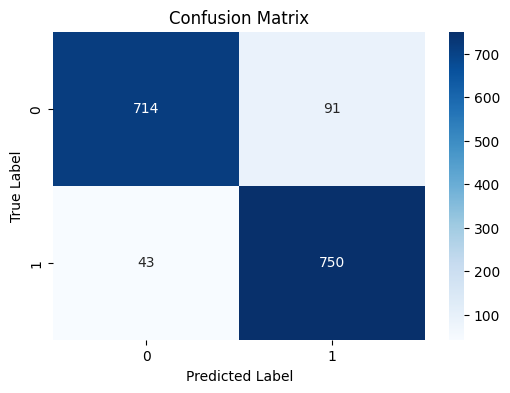

In [ ]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, predictions)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Lr_c.classes_, yticklabels=Lr_c.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Train a simple Logistic Regression model using TF-IDF features
Lr_TFIDF = LogisticRegression()
Lr_TFIDF.fit(x_train_Tfidf, y_encoded_train)

# Make predictions
y_pred = Lr_TFIDF.predict(x_test_Tfidf)

# Evaluate the model
accuracy = accuracy_score(y_encoded_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, y_pred))

Model Accuracy: 0.9143
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       805
           1       0.89      0.94      0.92       793

    accuracy                           0.91      1598
   macro avg       0.92      0.91      0.91      1598
weighted avg       0.92      0.91      0.91      1598



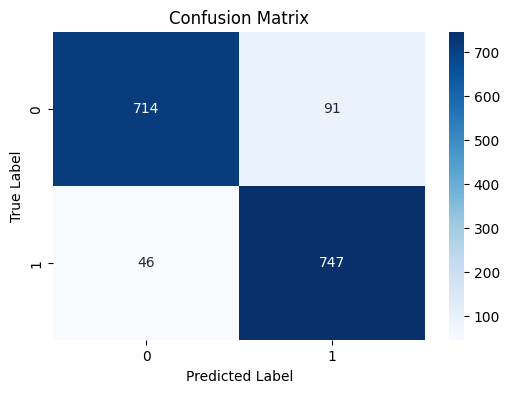

In [ ]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Lr_TFIDF.classes_, yticklabels=Lr_TFIDF.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Multinomial Naïve Bayes Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the model
nb_c = MultinomialNB()
nb_c.fit(x_train_feat, y_encoded_train)

# Predict on the test set
nb_predictions = nb_c.predict(x_test_feat)

accuracy_nb = accuracy_score(y_encoded_test, nb_predictions)
print(f"Model NB for CountVectorizer Accuracy: {accuracy_nb:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, nb_predictions))

Model NB for CountVectorizer Accuracy: 0.9168
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       805
           1       0.92      0.91      0.92       793

    accuracy                           0.92      1598
   macro avg       0.92      0.92      0.92      1598
weighted avg       0.92      0.92      0.92      1598



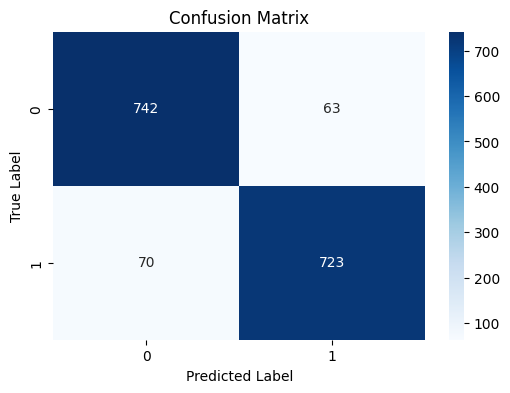

In [ ]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, nb_predictions)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=nb_c.classes_, yticklabels=nb_c.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Train a simple NB model using TF-IDF features**

In [ ]:
# Initialize and train the model
nb_TFIDF = MultinomialNB()
nb_TFIDF.fit(x_train_Tfidf, y_encoded_train)

# Predict on the test set
nb_predictions_TFidf = nb_TFIDF.predict(x_test_Tfidf)

accuracy_nb_TFIDF = accuracy_score(y_encoded_test, nb_predictions_TFidf)
print(f"Model NB for TF-IDF Accuracy: {accuracy_nb_TFIDF:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, nb_predictions_TFidf))

Model NB for TF-IDF Accuracy: 0.9149
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92       805
           1       0.91      0.92      0.91       793

    accuracy                           0.91      1598
   macro avg       0.91      0.91      0.91      1598
weighted avg       0.91      0.91      0.91      1598



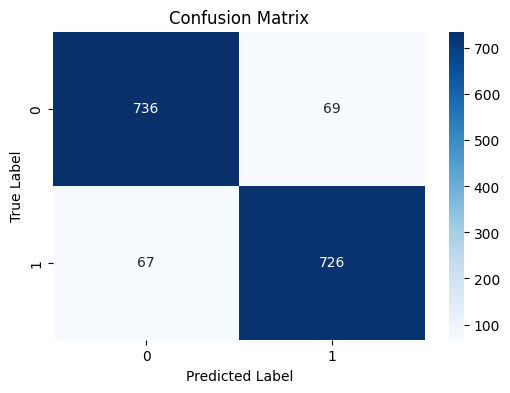

In [ ]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, nb_predictions_TFidf)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=nb_TFIDF.classes_, yticklabels=nb_TFIDF.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## SVM

In [ ]:
from sklearn.svm import LinearSVC
# Train SVM on CountVectorizer features
svm_model_count = LinearSVC()
svm_model_count.fit(x_train_feat, y_encoded_train)

# Predict on the test set
predi_count = svm_model_count.predict(x_test_feat)

accuracy_count = accuracy_score(y_encoded_test, predi_count)
print(f"Model SVM for CountVectorizer Accuracy: {accuracy_count:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, predi_count))

Model SVM for CountVectorizer Accuracy: 0.9068
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91       805
           1       0.89      0.92      0.91       793

    accuracy                           0.91      1598
   macro avg       0.91      0.91      0.91      1598
weighted avg       0.91      0.91      0.91      1598



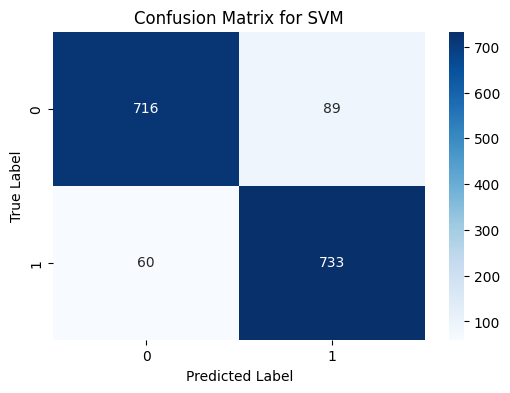

In [ ]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, predi_count)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model_count.classes_, yticklabels=svm_model_count.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM')
plt.show()

In [ ]:
# Train SVM on CountVectorizer features
svm_model_TFIDF = LinearSVC()
svm_model_TFIDF.fit(x_train_Tfidf, y_encoded_train)

# Predict on the test set
predi_TFIDF = svm_model_TFIDF.predict(x_test_Tfidf)

accuracy_TFIDF = accuracy_score(y_encoded_test, predi_TFIDF)
print(f"Model SVM for TF-IDF Accuracy: {accuracy_TFIDF:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, predi_TFIDF))

Model SVM for TF-IDF Accuracy: 0.9130
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       805
           1       0.90      0.93      0.91       793

    accuracy                           0.91      1598
   macro avg       0.91      0.91      0.91      1598
weighted avg       0.91      0.91      0.91      1598



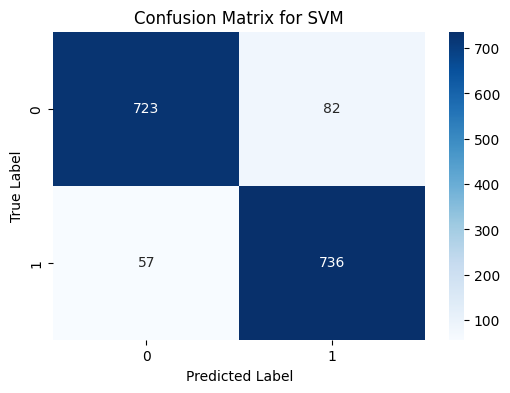

In [ ]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, predi_TFIDF)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model_TFIDF.classes_, yticklabels=svm_model_TFIDF.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM')
plt.show()

In [ ]:
#Save the best model :
import joblib

joblib.dump(Lr_c, 'logistic_regression_model_headline.pkl')


['logistic_regression_model_headline.pkl']

## Predictions on Validation data

In [ ]:
model = joblib.load('logistic_regression_model_headline.pkl')

In [ ]:
# Load the validation dataset
validation_data = pd.read_csv('validation_data.csv')

# Extract the title column
X_val = validation_data['title']

# Apply the same transformation to test data
X_val_fea = apply_features(X_val, vectorizer)

# Make predictions on the validation set
predictions = model.predict(X_val_fea)

# Replace label "2" with model predictions (0 or 1)
validation_data['label'] = predictions


# Save the file while
validation_data.to_csv('predicted_val_data.csv', sep=',', index=False)

## CNN Model

In [ ]:
#load pre-trained Word2Vec model (Google News 300)
w2v_model = api.load("word2vec-google-news-300")
embedding_dim = 300  #word vector size


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#function to convert text into a list of word vectors
def text_to_sequence(text, model):
    words = word_tokenize(text.lower()) #Tokenize text into words
    return [model[word] for word in words if word in model]  #extract available word vectors


In [ ]:
#convert text into lists of word vectors
df['vectors'] = df['title'].apply(lambda x: text_to_sequence(str(x), w2v_model))


In [ ]:
#set a fixed sentence length (Padding/Truncating)
max_length = 30

#prepare input data (X)
X = pad_sequences(df['vectors'], maxlen=max_length, dtype='float32', padding='post', truncating='post', value=0.0)

#prepare labels (y)
y = df['label'].values

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(max_length, embedding_dim)),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # إضافة L2 Regularization
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


#compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#add early stop
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8127 - loss: 0.6948 - val_accuracy: 0.9447 - val_loss: 0.2728
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9492 - loss: 0.2123 - val_accuracy: 0.9507 - val_loss: 0.1979
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9612 - loss: 0.1439 - val_accuracy: 0.9616 - val_loss: 0.1532
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9679 - loss: 0.1153 - val_accuracy: 0.9582 - val_loss: 0.1490
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9702 - loss: 0.1063 - val_accuracy: 0.9627 - val_loss: 0.1261
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9760 - loss: 0.0877 - val_accuracy: 0.9623 - val_loss: 0.1302
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9779 - loss: 0.0820 - val_accuracy: 0.9604 - val_loss: 0.1252
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9820 - loss: 0.0703 - val_accuracy: 0

In [ ]:
#evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Improved CNN Model Accuracy: {accuracy:.4f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9679 - loss: 0.1050
Improved CNN Model Accuracy: 0.9683


In [ ]:
#save the model
model.save("cnn_model_headline.h5")